# Table of Contents
 <p><div class="lev2 toc-item"><a href="#parametric-fits" data-toc-modified-id="parametric-fits-01"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>parametric fits</a></div>

In [45]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

In [1]:
# import sys

In [4]:
# sys.path.append("/Users/sebastian/work/git/stk/ml/waveforms/nonspin")

In [10]:
# import utils as ns_utils
# from waveform import SingleModeNRWaveform

In [27]:
import numpy as np

In [49]:
import pycbc
from pycbc.waveform import get_fd_waveform
from pycbc.waveform import amplitude_from_frequencyseries, phase_from_frequencyseries

In [17]:
from pycbc import pnutils

In [19]:
pnutils.mtotal_eta_to_mass1_mass2(100, 0.25)

(50.0, 50.0)

In [20]:
import phenom

In [21]:
phenom.m1_m2_M_q(100, 1)

(50.0, 50.0)

In [78]:
mtot=100
npts=20
qlist = np.linspace(1, 5, npts)
amp=[None]*npts
phase=[None]*npts

In [79]:
qlist

array([1.        , 1.21052632, 1.42105263, 1.63157895, 1.84210526,
       2.05263158, 2.26315789, 2.47368421, 2.68421053, 2.89473684,
       3.10526316, 3.31578947, 3.52631579, 3.73684211, 3.94736842,
       4.15789474, 4.36842105, 4.57894737, 4.78947368, 5.        ])

In [319]:
for i,q in enumerate(qlist):
    print(i)
    m1,m2 = phenom.m1_m2_M_q(mtot, q)
    hp, _ = get_fd_waveform(mass1=m1, mass2=m2, delta_f=0.01, f_lower=30., approximant="IMRPhenomD")
    amp[i] = amplitude_from_frequencyseries(hp)
    phase[i] = phase_from_frequencyseries(hp)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


(30, 500)

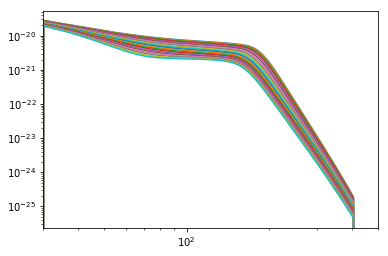

In [259]:
plt.figure()
for i in range(len(amp)):
    plt.loglog(amp[i].sample_frequencies, amp[i])
plt.xlim(30, 500)

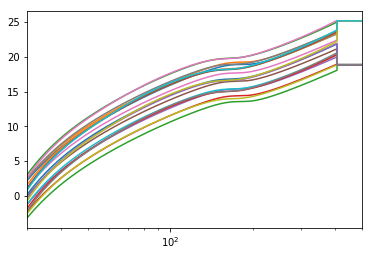

In [260]:
plt.figure()
for i in range(len(amp)):
    plt.plot(phase[0].sample_frequencies, phase[i])
plt.xlim(30, 500)
plt.xscale('log')

In [320]:
ff1 = 30
ff2 = 300
common_f = phase[0].sample_frequencies
mask_f = (common_f >= ff1) & (common_f <= ff2)
common_f = common_f[ mask_f ]


common_amp = [None]*len(amp)
common_phase= [None]*len(phase)
for i in range(len(common_amp)):
    common_amp[i] = amp[i][mask_f]
    common_phase[i] = phase[i][mask_f]
#     common_phase[i] -= common_phase[i][0]


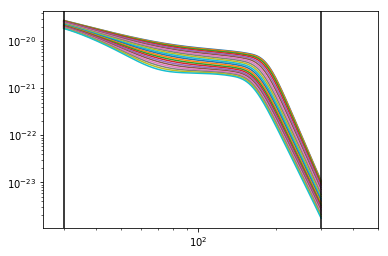

In [262]:
plt.figure()
for i in range(len(amp)):
    plt.loglog(common_f, common_amp[i])
plt.xlim(25, 500)
plt.axvline(ff1,c='k')
plt.axvline(ff2,c='k')

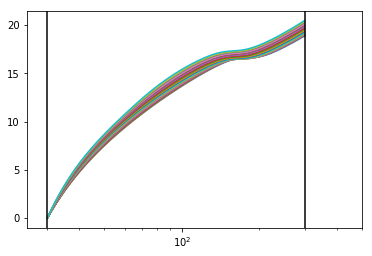

In [265]:
plt.figure()
for i in range(len(amp)):
    plt.plot(common_f, common_phase[i])
plt.xlim(25, 500)
plt.xscale('log')
plt.axvline(ff1,c='k')
plt.axvline(ff2,c='k')

In [266]:
# u, s, vh          = np.linalg.svd(np.array(common_amp).transpose(), full_matrices=False)
u, s, vh          = np.linalg.svd(np.array(common_phase).transpose(), full_matrices=False)

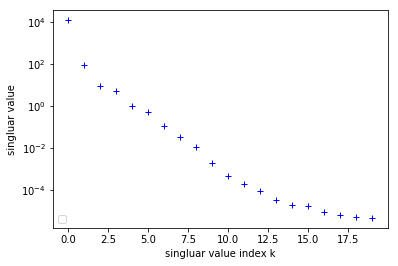

In [267]:
# first, lets check the claim that peak-aligned training sets are easier to approximate.
# From the above discussion, faster decaying singular values means the matrix/model is easier
# to compress
plt.semilogy(range(len(common_phase)),s,'b+')
plt.ylabel('singluar value')
plt.xlabel('singluar value index k')
plt.legend(loc=3)

In [268]:
vh.shape

(20, 20)

In [269]:
u.shape

(27001, 20)

In [270]:
common_f.shape

(27001,)

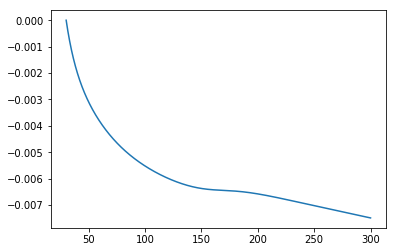

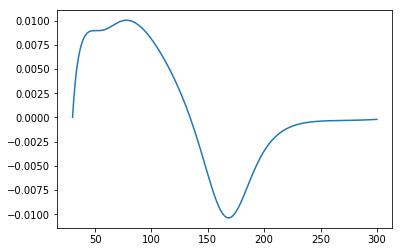

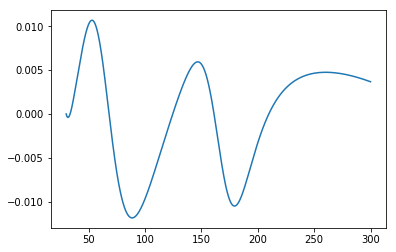

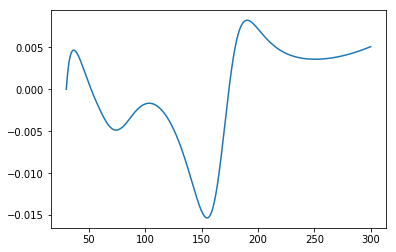

In [271]:
for i in range(4):
    plt.figure(i)
    plt.plot(common_f, u[:,i])

In [294]:
# Decide on how many column vectors to use as the basis
basis_size = 3
# basis_size = 7
# More vectors -> more accuracy but also more computational cost 
# basis_size = -1
basis_set  = u[:,0:basis_size]

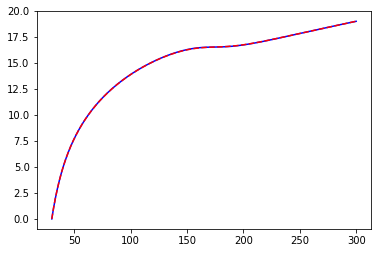

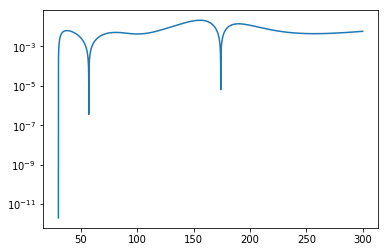

In [295]:
# Select a waveform to approximate 
h_i = common_phase[5]

# compute its representation in the linear space defined by the span of the basis set
proj_coeffs = np.dot(basis_set.transpose(), h_i.conjugate()) 
h_approx = np.dot(basis_set, proj_coeffs.transpose())
h_approx = h_approx.transpose()

# plot the original waveform, its compressed version, and the error
plt.figure(1)
plt.plot(common_f,h_i,'blue')
plt.plot(common_f,h_approx,'r--')

plt.figure(2)
wave_err = np.abs(h_i - h_approx)
plt.semilogy(common_f,wave_err)

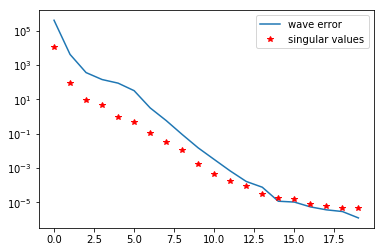

In [296]:
# Select a waveform to approximate 
h_i = common_phase[0]

errors = []
bss = range(len(qlist))
for bs in bss:
    basis_set_local  = u[:,0:bs]

    # compute its representation in the linear space defined by the span of the basis set
    proj_coeffs = np.dot(basis_set_local.transpose(), h_i.conjugate()) 
    h_approx = np.dot(basis_set_local, proj_coeffs.transpose())
    h_approx = h_approx.transpose()
    
    wave_err = np.abs(h_i - h_approx)
    errors.append(np.sum(wave_err))
    
# plot the original waveform, its compressed version, and the error
plt.semilogy(bss,errors,label='wave error')
plt.semilogy(range(len(qlist)),s,'r*',label='singular values')
plt.legend()

In [297]:
# Import RomPy. if its not in your PYTHONPATH, add it now
import rompy as rp

In [298]:
eim = rp.EmpiricalInterpolant(basis_set.transpose(), verbose=True) # Note the transpose


Step 	Nodes
1 	27000
2 	13843
3 	5734


In [299]:
# the most important pieces of information are the interpolation times T_i and the basis B_i
eim_indicies = eim.indices
B = eim.B

In [300]:
B

array([[-4.31397016e-11,  4.42250055e-04,  8.85875034e-04, ...,
         1.00003993e+00,  1.00001997e+00,  1.00000000e+00],
       [ 2.66401391e-11, -8.87034110e-04, -1.77344958e-03, ...,
        -3.42636876e-05, -1.71326219e-05, -1.52728657e-17],
       [ 2.93859130e-11,  1.03885293e-03,  2.07438468e-03, ...,
        -5.01564449e-05, -2.50804137e-05, -1.87096562e-17]])

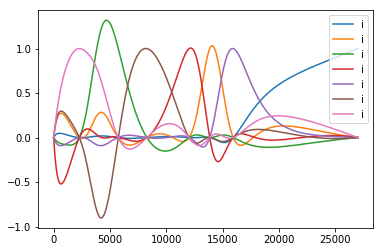

In [279]:
for i in range(len(B)):
    plt.plot(B[i], label='i')
plt.legend()

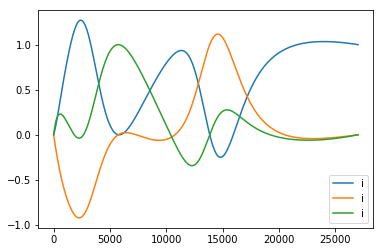

In [301]:
for i in range(len(B)):
    plt.plot(B[i], label='i')
plt.legend()

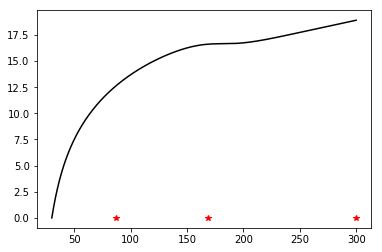

In [302]:
# Lets see what time the empirical inteprolation method has discovered as most important:
f_eim = common_f[eim_indicies]

plt.figure(1)
plt.plot(common_f,common_phase[0],'k')
plt.plot(f_eim,np.zeros_like(f_eim),'r*')


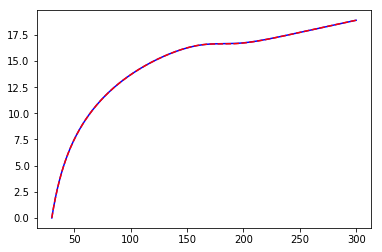

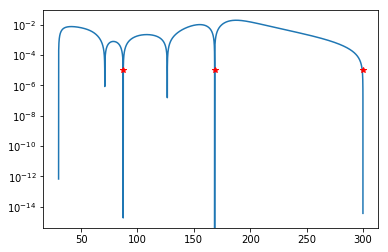

In [303]:
# Select a waveform to approximate 
h_i = common_phase[0]

# compute its empirical interpolant representation 
h_eim =  h_i[eim_indicies]
h_approx = np.dot(B.transpose(), h_eim)

# plot the original waveform, its empirically interpolated version, and the error
plt.figure(1)
plt.plot(common_f,h_i,'blue')
plt.plot(common_f,h_approx,'r--')
# plt.xlim(3.5,3.6)

plt.figure(2)
plt.semilogy(common_f,np.abs(h_i - h_approx))
plt.semilogy(f_eim,np.ones_like(f_eim)*1e-5,'r*')

## parametric fits

In [304]:
len(common_phase)

20

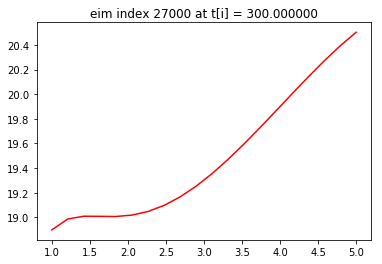

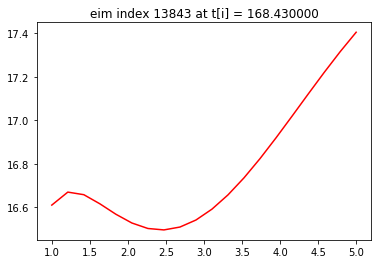

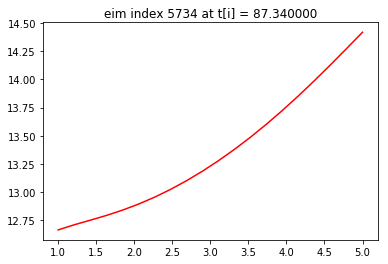

In [308]:
# First, view the data we need to fit
h_training_eim = np.array(common_phase).transpose()[eim_indicies,:]

for counter, i in enumerate(eim_indicies):
    plt.figure(counter)
    plt.title("eim index %i at t[i] = %f"%(i,common_f[i]))
    plt.plot(qlist,np.real(h_training_eim[counter,:]),'r',label='real' )
#     plt.plot(qlist,np.imag(h_training_eim[counter,:]),'k--',label='imag' )

In [309]:
from scipy.interpolate import splrep, splev

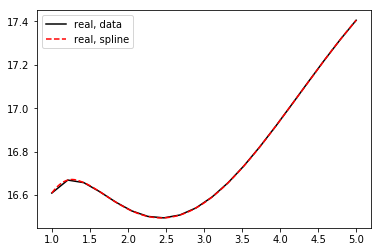

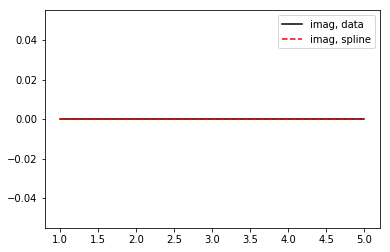

In [310]:
# lets first show how this works on a data piece 
eim_indx = 1
h_eim_real_spline = splrep(qlist, np.real(h_training_eim[eim_indx,:]),k=2) # degree 2
h_eim_imag_spline = splrep(qlist, np.imag(h_training_eim[eim_indx,:]),k=2) # degree 2

q_dense = np.linspace(min(qlist),max(qlist),300)

plt.figure(1)
plt.plot(qlist,np.real(h_training_eim[eim_indx,:]),'k',label ='real, data')
plt.plot(q_dense,splev(q_dense,h_eim_real_spline),'r--',label ='real, spline')
plt.legend()

plt.figure(2)
plt.plot(qlist,np.imag(h_training_eim[eim_indx,:]),'k',label ='imag, data')
plt.plot(q_dense,splev(q_dense,h_eim_imag_spline),'r--',label ='imag, spline')
plt.legend()

In [311]:
# Now find the spline interpolant for all of the coefficients 
h_eim_real_spline = [splrep(qlist, np.real(h_training_eim[i,:]),k=2) for i in range(len(eim_indicies))]
h_eim_imag_spline = [splrep(qlist, np.imag(h_training_eim[i,:]),k=2) for i in range(len(eim_indicies))]

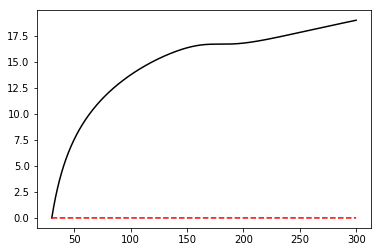

In [312]:
# The full surrogate can now be evaluated by evaluating the splines, and using the 
# empirical interpolation representation

q=1.2 # mass ratio value to predict now model for

h_eim = np.array([splev(q, h_eim_real_spline[j])  \
             + 1.0j*splev(q,h_eim_imag_spline[j]) for j in range(len(eim_indicies))])
h_approx = np.dot(B.transpose(), h_eim)

# plot the original waveform, its empirically interpolated version, and the error
plt.figure(1)
plt.plot(common_f,np.real(h_approx),'k')
plt.plot(common_f,np.imag(h_approx),'r--')

In [313]:
def surrogate(q):
    h_eim = np.array([splev(q, h_eim_real_spline[j])  \
             + 1.0j*splev(q,h_eim_imag_spline[j]) for j in range(len(eim_indicies))])
    h_approx = np.dot(B.transpose(), h_eim)
    return np.real(h_approx)

In [314]:
%time surrogate_evals = np.array([surrogate(q) for q in qlist])

CPU times: user 15 ms, sys: 10.4 ms, total: 25.4 ms
Wall time: 19.9 ms


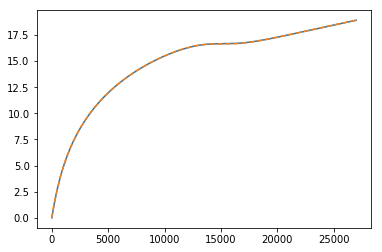

In [315]:
plt.figure()
plt.plot(common_phase[0])
plt.plot(surrogate_evals[0], ls='--')
# plt.xlim(7000, 7700)

In [316]:
h_error = np.abs(np.array(common_phase) - surrogate_evals)
h_inf =  h_error.max(axis=1) #/ np.abs(common_phase).max(axis=0)

In [317]:
h_inf

array([0.02049568, 0.02708259, 0.01975982, 0.00720175, 0.01789266,
       0.02501962, 0.02992716, 0.02966399, 0.02454911, 0.01608761,
       0.00700016, 0.00650783, 0.01375814, 0.02062038, 0.02426573,
       0.0239503 , 0.01920894, 0.0104111 , 0.00603212, 0.02798559])

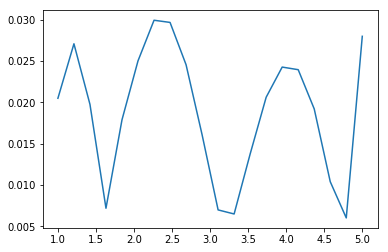

In [318]:
plt.plot(qlist,h_inf)